# Examples: PSF Photometry with astropy.photutils

Examples from astropy.photutils documentation, and the https://github.com/astropy/photutils-datasets package.

## PSF photometry on artificial Gaussian stars

In [1]:
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting

## Make sure we have photutils installed

Given we're using Anaconda, let's install photutils with `conda`:

In [2]:
! conda install -c defaults -c astropy photutils --yes

Solving environment: done

# All requested packages already installed.



In [3]:
import photutils
from photutils import psf

photutils.__version__

'0.4'

Tweak some matplotlib defaults so we don't have to specify these over and over again:

In [4]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (15,10)
rcParams['image.interpolation'] = 'none'

## First lets experiment with fake image of a single star with Gaussian PSF

In [5]:
gmod = models.Gaussian2D(x_stddev=5, y_stddev=5)

((-27.5, 27.5), (-27.5, 27.5))

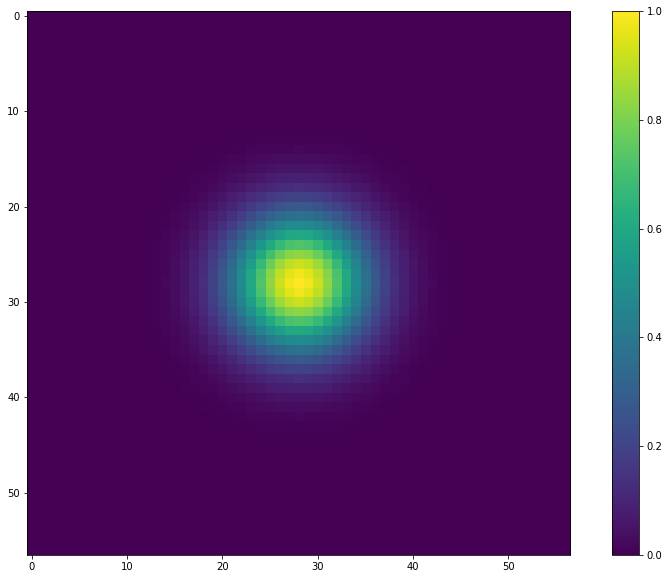

In [6]:
#without arguments, `render` creates an image based on the bounding_box, which defaults to 5.5 sigma
plt.imshow(gmod.render(), vmin=0, vmax=1)
plt.colorbar()
gmod.bounding_box

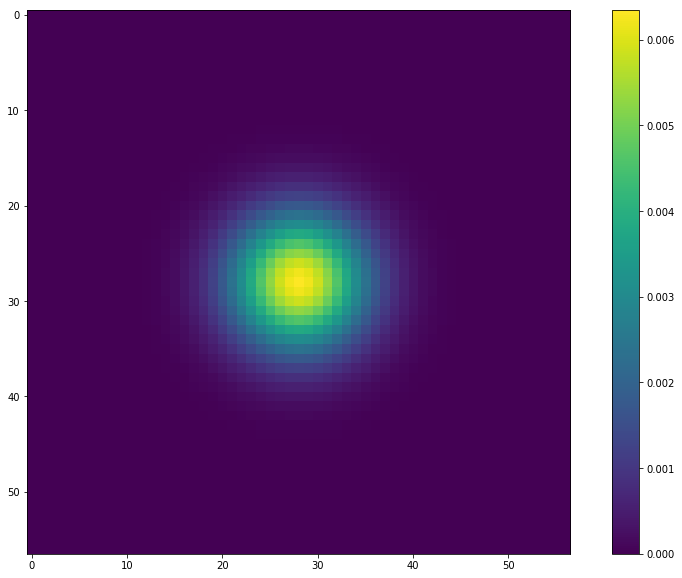

In [7]:
# this is a subtly different Gaussian that is integrated over pixels
gmodi = psf.IntegratedGaussianPRF(sigma=5)

# make it match the above plot
gmodi.bounding_box = gmod.bounding_box

plt.imshow(gmodi.render())
plt.colorbar()

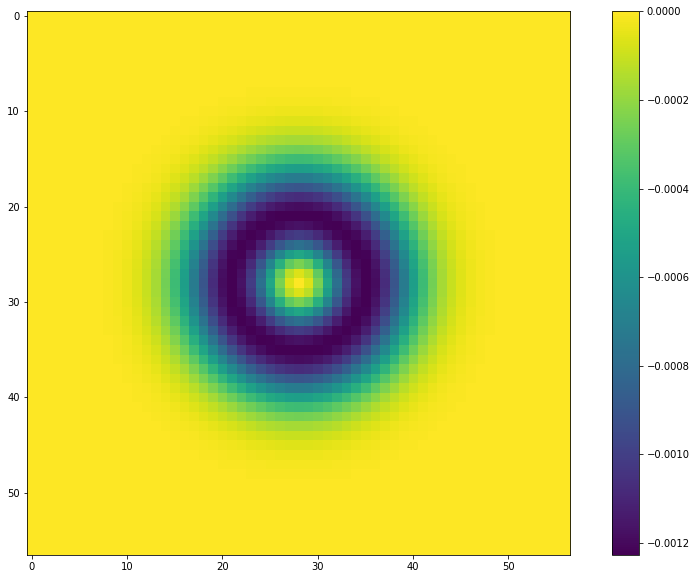

In [8]:
# also compare the IntegratedGaussianPRF to the Gaussian2DModel.  Note that we need to re-scale the flux to match the Gaussian2D
plt.imshow(gmod.render() - gmodi.render()/gmodi.render().max())
plt.colorbar()

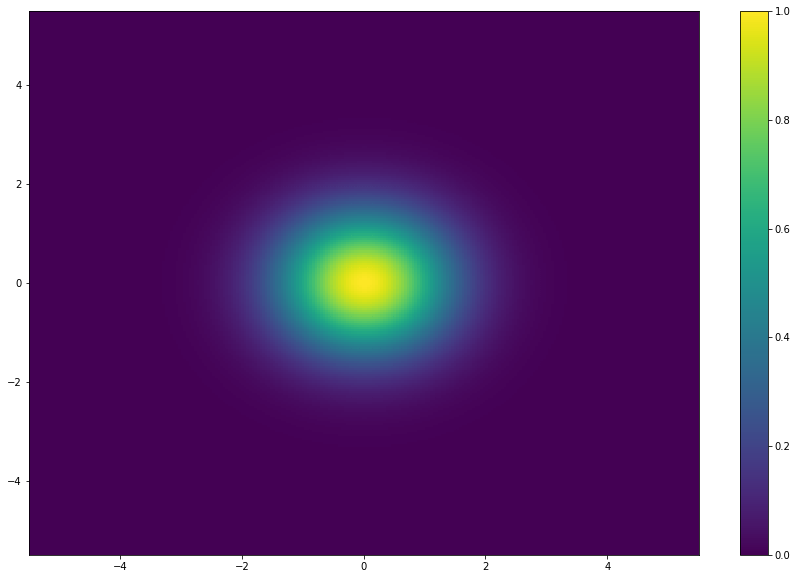

In [9]:
# To render into a specific set of x/y coordinates, 
# pass that into the `coords`  argument of `render
coo = np.mgrid[-5.5:5.5:256j, -5.5:5.5:256j]

gmod.x_stddev = gmod.y_stddev = 1
gmod.bounding_box = None

plt.pcolor(*coo, gmod.render(coords=coo), vmin=0, vmax=1)
plt.xlim(-5.5,5.5)
plt.ylim(-5.5,5.5)
plt.colorbar()

## Now create an image that has a few stars

In [10]:
nstars = 20
imgshape = (256, 256)
poisson_scale = 15
bkg = 1
flux_scale = 750

np.random.seed(12345)

xs, ys = np.random.rand(2, nstars)*204 + 18 # centers should be at least 3sig from the edge
fluxes = (np.random.rand(nstars)+.5)*flux_scale

0.0666666666667 6.76804040544 8.13333333333


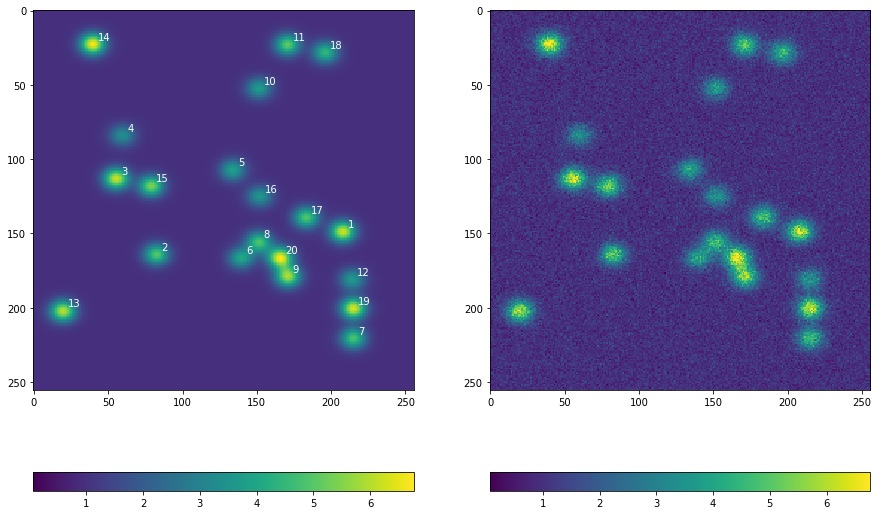

In [11]:
x_stddev=6
y_stddev=5

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

# perfect flux image with slightly elliptical PSF
im = np.ones(imgshape)*bkg

for row in intab:
    gmod_star = models.Gaussian2D(
        amplitude=row['flux_0']/(2*np.pi*x_stddev*y_stddev),
        x_mean=row['x_0'],
        y_mean=row['y_0'],
        x_stddev=x_stddev,
        y_stddev=y_stddev)
    gmod_star.render(im)
    
# poisson-ified image with slightly elliptical PSF
pim = np.random.poisson(poisson_scale*im)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(im, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')
for i, row in enumerate(intab):
    plt.annotate(str(i+1), (row['x_0'], row['y_0']), 
                 (5, 5), textcoords='offset points', 
                 color='w')

plt.subplot(1,2,2)
plt.imshow(pim, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

print(np.min(pim), np.max(im), np.max(pim))

0.133333333333 6.76804040544 7.8


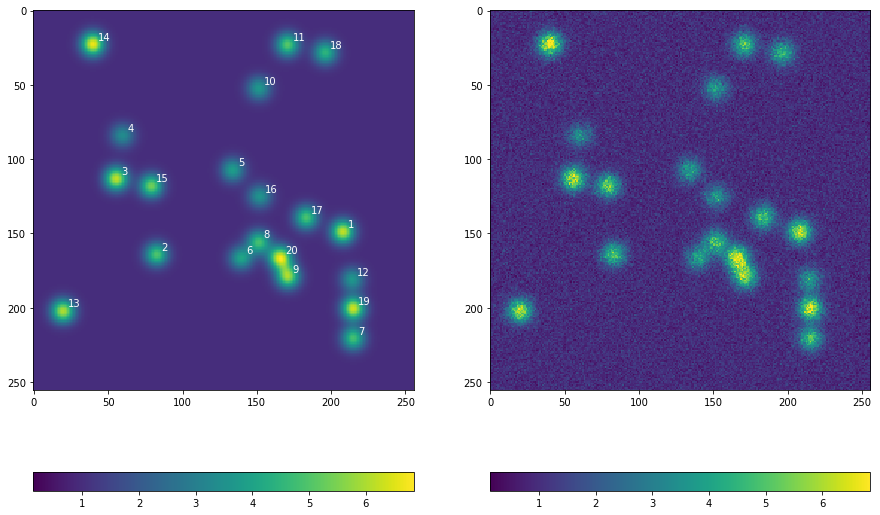

In [12]:
round_sigma = (x_stddev*y_stddev)**0.5

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

# perfect flux image with round IntegratedGaussianPRF
imi = np.ones(imgshape)*bkg

for row in intab:
    gmodi_star = psf.IntegratedGaussianPRF(
        flux=row['flux_0'],
        x_0=row['x_0'],
        y_0=row['y_0'],
        sigma=round_sigma,
    )
    gmodi_star.render(imi)
    
# poisson-ified image with round IntegratedGaussianPRF
pimi = np.random.poisson(poisson_scale*imi)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(imi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')
for i, row in enumerate(intab):
    plt.annotate(str(i+1), (row['x_0'], row['y_0']), 
                 (5, 5), textcoords='offset points', 
                 color='w')

plt.subplot(1,2,2)
plt.imshow(pimi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

print(np.min(pimi), np.max(im), np.max(pimi))

# Some utility functions used for plotting below 

In [13]:
def residuals_psf_sub_table(outtab, title=None):
    plt.subplot(3,1,1)
    if title is not None:
        plt.title(title)
    plt.scatter(np.arange(len(outtab))+1, (outtab['flux_fit']-outtab['flux_0'])*100./outtab['flux_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('fluxperc')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,2)
    plt.scatter(np.arange(len(outtab))+1, outtab['x_fit']-outtab['x_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dx')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,3)
    plt.scatter(np.arange(len(outtab))+1, outtab['y_fit']-outtab['y_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dy')
    plt.xlim(0.5, len(outtab)+.5)
    
    plt.tight_layout()

In [14]:
# note that this assumes the underlying image is the same as the above
def compare_psf_sub(subim, pim, im, kw1s={}, kw2s={}, kw3s={}, kw4s={}):
    subps = (2, 2)
    cborient = 'vertical'
    
    plt.subplot(*subps,1)
    plt.imshow(pim, **kw1s)
    plt.colorbar(orientation=cborient)
    plt.title('Base image')

    plt.subplot(*subps,2)
    plt.imshow(subim, **kw2s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF subtracted image')
    print("Subtracted image bkg-sub mean:", np.mean(subim-bkg), 'and SD:', np.std(subim-bkg))

    plt.subplot(*subps,3)
    plt.imshow(im, **kw3s)
    plt.colorbar(orientation=cborient)
    plt.title('Real noise-free images')

    plt.subplot(*subps,4)
    plt.imshow(pim-subim, **kw4s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF images')

# Now do the actual PSF fitting and subtraction

In [15]:
psf_guess = psf.IntegratedGaussianPRF(flux=1, sigma=round_sigma)

### Start with perfect inputs 

In [16]:
psf_guess.flux.fixed = psf_guess.x_0.fixed = psf_guess.y_0.fixed = False

Assuming you know the flux and locations perfectly, how well can you subtract?

Subtracted image bkg-sub mean: -0.00124796865474 and SD: 0.28667499614


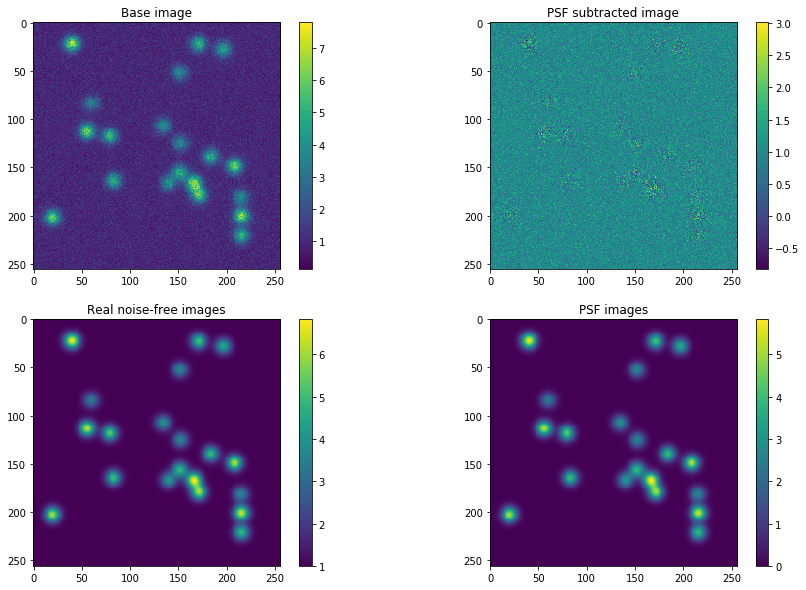

In [17]:
subimi = psf.subtract_psf(pimi, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subimi, pimi, imi)

Now what about when the PSF doesn't quite match? (The image was generated with a slightly elliptical PSF)

Subtracted image bkg-sub mean: -0.000991620998489 and SD: 0.294870110113


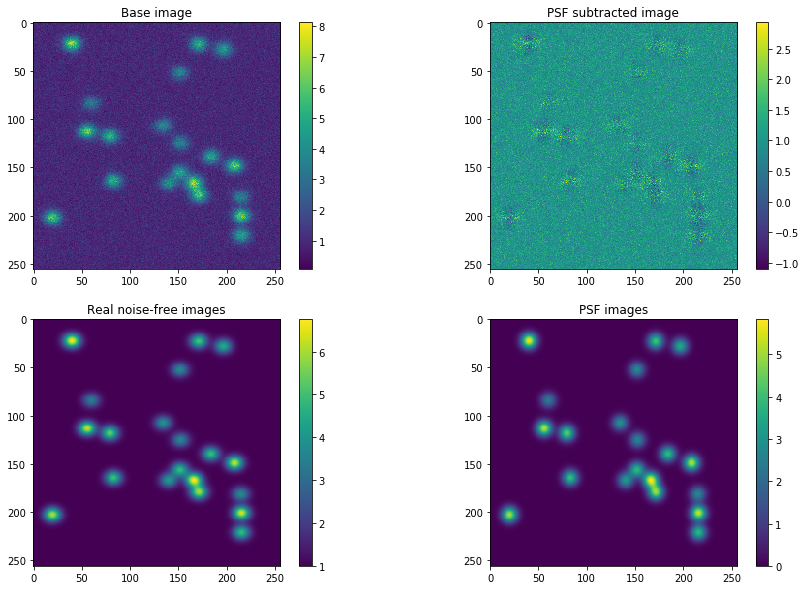

In [18]:
subim = psf.subtract_psf(pim, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subim, pim, im)

The "dipole" structures observed in the residual image are characteristic of poor PSF fit in one direction.

They're also very frequent when taking image differencing with imperfectly matched PSFs.

## Now try actually *fitting* the target stars

In [19]:
# fitting region used by all the below 
fitshape = (8,8)

### Perfect info on location/flux

Start with perfect initial gluesses for the flux and location, starting with a perfect PSF model 

In [20]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

daogroup = DAOGroup(crit_separation=8)    # An algorithm to divide up the image into groups of overlapping stars
mmm_bkg = MMMBackground()                 # Determine the image background using the DAOPHOT MMM algorithm
fitter = LevMarLSQFitter()                # Levenberg-Marquardt algorithm and least squares statistic.
gaussian_prf = IntegratedGaussianPRF(sigma=2.05)  # Gaussian PSF guess
gaussian_prf.sigma.fixed = False

psf_photometry = psf.BasicPSFPhotometry(group_maker=daogroup,   # The Photometry object
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_guess,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))

In [21]:
# with integrated psf
outtabi = psf_photometry(image = pimi, init_guesses=intab)
outtabi.show_in_notebook()

idx,flux_0,x_0,y_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
0,988.762508542,207.641682935,149.064966891,1,1,207.652599647,149.343952451,1013.20083771,11.7116137952,0.125329103482,0.125371902785
1,750.167064626,82.5406131347,164.360538646,2,2,82.5519833004,164.38832711,763.245665718,10.592036381,0.150290635082,0.150277014145
2,982.642056602,55.5194375821,113.390197473,3,3,55.5235310445,113.428702015,1016.52147886,13.6518123136,0.145343388383,0.14532652909
3,446.976394308,59.7302968248,84.419274218,4,4,59.6289847908,84.6386331968,461.857183479,10.290145046,0.240434474837,0.240999423451
4,539.212532799,133.815905933,107.687499601,5,5,133.785017834,107.748388835,559.05529715,10.9233268426,0.212207654045,0.212236976408
5,569.039296202,139.491119408,166.85657288,6,6,140.083071218,166.446532572,623.789490668,11.2183577696,0.192864161156,0.19142484102
6,726.079315465,214.760962026,220.778975524,7,7,215.080080613,220.924747218,751.139119198,10.5748564561,0.153084731408,0.153068593265
7,719.529901953,151.248127762,156.082237202,8,8,151.355657328,156.486424611,764.546411102,13.4049188567,0.189727435291,0.18990423751
8,907.132335157,170.776954057,179.327793641,9,9,170.214835488,178.065581709,1040.58721205,12.9803045494,0.133218131198,0.133472672558
9,508.539754413,151.328253654,52.8665085897,10,10,150.643114951,52.7404946107,539.171446551,10.2961324984,0.207245647197,0.207171593327


Plot the results:

Subtracted image bkg-sub mean: -0.012073888745 and SD: 0.298785534417


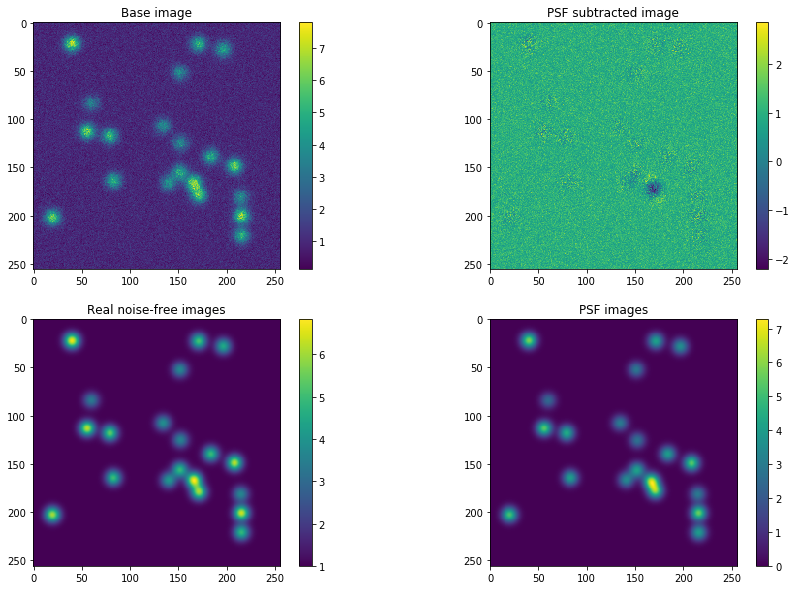

In [22]:
subimi = psf.subtract_psf(pimi, psf_guess, outtabi)
compare_psf_sub(subimi, pimi, imi)

This looks generally good, except for the few stars that overlap.

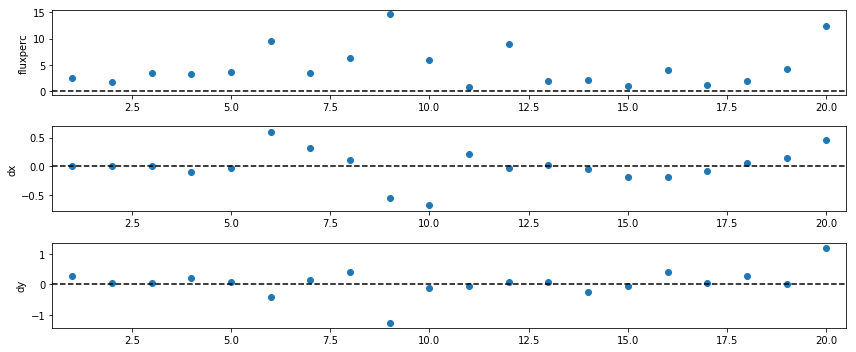

In [23]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And now with a slightly-wrong model (round model, elliptical PSF)

In [24]:
outtab = psf_photometry(image=pim, init_guesses=intab)
outtab.show_in_notebook()

idx,flux_0,x_0,y_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
0,988.762508542,207.641682935,149.064966891,1,1,207.729081294,149.061196226,1000.93845528,15.4109893283,0.167321538074,0.16726150995
1,750.167064626,82.5406131347,164.360538646,2,2,82.3676803449,164.340420905,796.899775202,13.2128090891,0.179377720152,0.179036072993
2,982.642056602,55.5194375821,113.390197473,3,3,55.5767102954,113.472388575,1014.56671016,12.9266279305,0.137852434285,0.137931749703
3,446.976394308,59.7302968248,84.419274218,4,4,59.5739968915,84.4449040159,472.162690278,10.299429945,0.236111181552,0.236185802807
4,539.212532799,133.815905933,107.687499601,5,5,133.87777379,107.266187286,569.973927332,10.5342265627,0.199300669979,0.200084351152
5,569.039296202,139.491119408,166.85657288,6,6,139.886199938,166.498113887,630.05921205,12.4053698909,0.21199047703,0.210977661279
6,726.079315465,214.760962026,220.778975524,7,7,214.7161124,220.73076929,723.865925014,12.3861081942,0.185778733003,0.185767818475
7,719.529901953,151.248127762,156.082237202,8,8,151.043403133,156.501929998,763.339868419,12.646542955,0.179408074875,0.179799294109
8,907.132335157,170.776954057,179.327793641,9,9,170.394288556,178.302515765,991.013798833,15.2225579504,0.165348525494,0.165493334512
9,508.539754413,151.328253654,52.8665085897,10,10,151.691804982,52.4151809132,536.550983518,10.9098340581,0.219124147904,0.218801143686


Subtracted image bkg-sub mean: -0.00902471157668 and SD: 0.302003246728


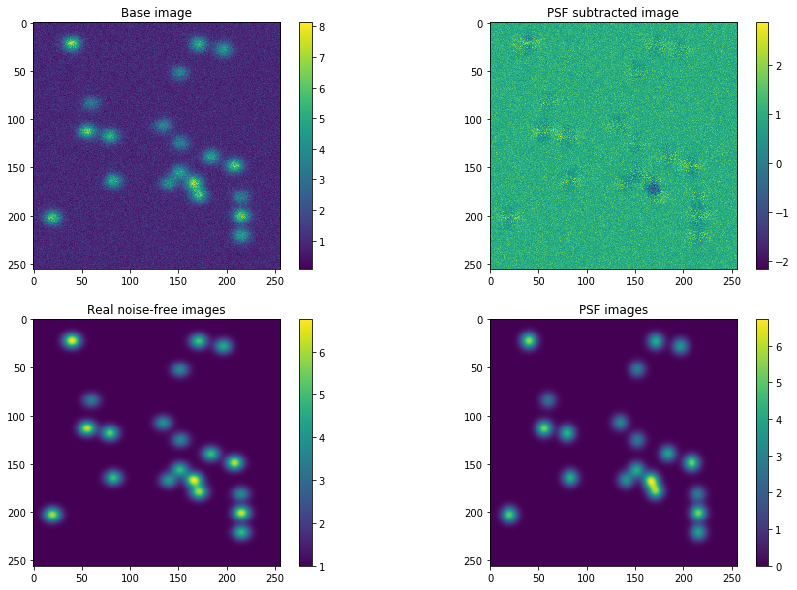

In [25]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

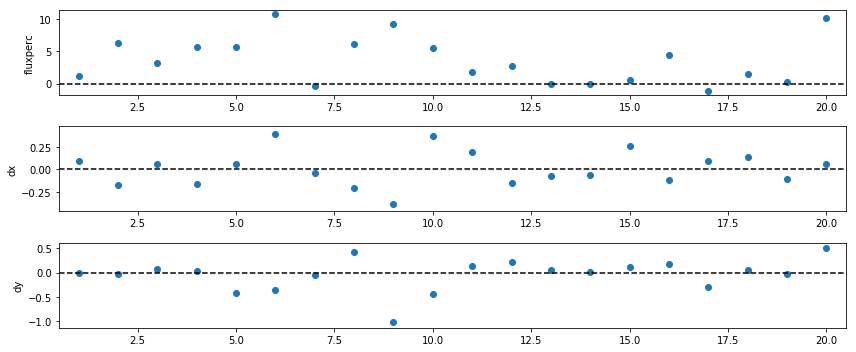

In [26]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)

## Iteratively fitting the PSF Photometry

To speed things up, let's take a look at a simpler example with simulated stars whose PSF is assumed to be Gaussian.

Let’s create an image with four overlapping stars:

In [27]:
import numpy as np
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
sigma_psf = 2.0
sources = Table()
sources['flux'] = [700, 800, 700, 800]
sources['x_mean'] = [12, 17, 12, 17]
sources['y_mean'] = [15, 15, 20, 20]
sources['x_stddev'] = sigma_psf*np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0, 0, 0, 0]
sources['id'] = [1, 2, 3, 4]
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, type='poisson', mean=6.,
                          random_state=1) +
         make_noise_image(tshape, type='gaussian', mean=0.,
                          stddev=2., random_state=1))

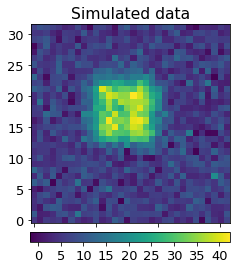

In [28]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.size'] = 13
import matplotlib.pyplot as plt
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
           origin='lower') 
plt.title('Simulated data') 
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04) 

Then let’s import the required classes to set up an `IterativelySubtractedPSFPhotometry` object:

In [29]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup, BasicPSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

Let’s then instantiate and use the objects:

In [30]:
bkgrms = MADStdBackgroundRMS()    # Calculate the background RMS in an array as using the median absolute deviation (MAD).
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

Note that the parameters values for the finder class, i.e., IRAFStarFinder, are completely chosen in an arbitrary manner and optimum values do vary according to the data.

As mentioned before, the way to actually do the photometry is by using `photometry` as a function-like call.

It’s worth noting that image does not need to be background subtracted. The subtraction is done during the photometry process with the attribute bkg that was used to set up photometry.

Now, let’s compare the simulated and the residual images:

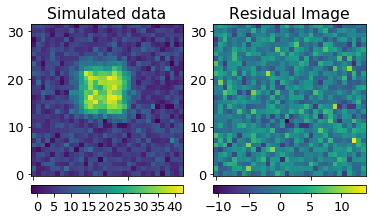

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest', origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()

In [32]:
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
12.4682793688,11.9427341652,14.8859432904,15.1203584316,1330.3366904,757.583848399,1,1,29.6341094566,0.113651947328,0.111805923129,1
16.6055429542,17.0269164118,15.4059611464,14.8936697165,1492.09749028,794.07104889,2,1,30.4828549893,0.108897072473,0.110502586545,1
12.5218865196,11.8939337094,19.6782370856,20.3128886346,1435.97493849,706.509471446,3,1,29.3699145585,0.12088859105,0.119866071805,1
16.5682160553,17.0215898338,19.396293882,19.9047455484,1524.49102265,827.676713592,4,1,30.2378163096,0.103439058367,0.106007879681,1


In [33]:
sources

flux,x_mean,y_mean,x_stddev,y_stddev,theta,id
int64,int64,int64,float64,float64,int64,int64
700,12,15,2.0,2.0,0,1
800,17,15,2.0,2.0,0,2
700,12,20,2.0,2.0,0,3
800,17,20,2.0,2.0,0,4
